# D-DUST Data Grid Processing Notebook

- - -

Check the following link for Data Management Plan and the Variable list table: <br>
**1. [Data Management Plan (DMP)](https://docs.google.com/document/d/1n3PVat7PBTG76JnINOkL2pvBZuKQlakZkTgqNj39oAQ/edit#)**<br>
**2. [Variables/data list table](https://docs.google.com/spreadsheets/d/1-5pwMSc1QlFyC8iIaA-l1fWhWtpqVio2/edit#gid=91313358)**

This notebook describes the physical variables selected for the project and how they are preprocessed.
These variables are divided into <u>4 categories</u>, as shown in the **variable/data list table**:
1. **Map Layer**: static layer used to describe Lombardy region morphology and its features (such as elevation, infrastructures, land use and cover etc.)
2. **Model**: data retrieved from a model that uses satellite and in-situ observations of meteorological and air quality data as input (such as ERA5, CAMS).
3. **Satellite**: data obtained directly from satellite observations (such as Sentinel-5P).
4. **Ground Sensor**: data retrieved from ground monitoring stations measuring air quality and meteorological variables.

First the other notebooks must be used in order to retrieve ready to be processed data in the same time range:
- [Satellite Variables Request Notebook](https://github.com/opengeolab/D-DUST/blob/WP2/Satellite%20Variables%20Request.ipynb): satellite data preparation
- [Model Variables Request Notebook](https://github.com/opengeolab/D-DUST/blob/WP2/Model%20Variables%20Request.ipynb): CAMS and ERA5 data preparation
- [Ground Sensor Variables Request Notebook](https://github.com/opengeolab/D-DUST/blob/WP2/Ground%20Sensor%20Variables%20Request%20-%20ARPA%20Lombardia.ipynb): ARPA ground monitoring sensors preparation
- [AQ_ESA Stations Notebook](https://github.com/opengeolab/D-DUST/blob/WP2/AQ_ESA_Stations.ipynb): ESA Air Quality stations preparation


## Import libraries

In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import scipy.interpolate
from scipy.interpolate import griddata
import rasterstats as rstat
import rioxarray
import shapely.speedups
shapely.speedups.enable()
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from shapely.geometry import shape
from shapely.geometry import  MultiLineString
from rasterio.enums import Resampling
import ipywidgets as widgets
import json
import warnings
warnings.filterwarnings('ignore')

C:\Users\Administrator\anaconda3\envs\ddust\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [3]:
# Import methods defined for the project
from functions import my_methods

In [4]:
# Get current working directory path
cwd = os.getcwd()

## Import grids

Three grids with different spatial resolution are used in this project:
1. **cams** grid: 0.1° x 0.1° resolution - Grid with CAMS Model spatial resolution.
2. **s5p** grid: 0.066° x 0.066° resolution - Grid with the Sentinel-5P approximate spatial resolution.
3. **arpa** grid: 0.01° x 0.01° resolution- Grid generated with at most one ARPA monitoring station for each pixel.

These grids are defined as bounding box of the Lombardy region layer applying a buffer of 20 km.

In [ ]:
# With this widget is possible to select from the dropdown list
name = widgets.Dropdown(
    options=['cams', 's5p', 'arpa'],
    description='name:',
    disabled=False)
name

In [ ]:
# To increase CAMS data resolution depending on the grid cell size (necessary zonal statistics calculation)
if name.value == 'cams':
    upscale_factor = 1  
if name.value == 's5p':
    upscale_factor = 10
if name.value == 'arpa':
    upscale_factor = 10  

grid_path = my_methods.select_grid(name.value)

Selection of **manuring periods** defined in the date.json file:

In [ ]:
d = open('date.json')
date = json.load(d)
year = date['year']
mais_week = date['mais_week']
rice_week = date['rice_week']
cereal_week = date['cereal_week']
year

In [ ]:
# Plot calendar of weeks defined in the .date.json file
calendar = my_methods.manuring_periods(year, mais_week, rice_week, cereal_week)

In [ ]:
# With this widget is possible to select from the dropdown list the required week
select_week = widgets.Dropdown(
    options=['mais_week', 'rice_week', 'cereal_week'],
    description='name:',
    disabled=False)
select_week

In [ ]:
# Select start and end date of the corresponding selected week:
start_date = calendar[date[select_week.value][0]][0]
end_date = calendar[date[select_week.value][-1]][-1]
print("For", select_week.value, "the starting date is", start_date,"and the ending date is" , end_date)
print(year)

In [ ]:
grid = gpd.read_file(cwd + grid_path)

In [ ]:
# Conversion for lengths and areas
m_to_km = 10**(-3)
m2_to_km2 = 10**(-6)

---

# Importing Map Layers

Map Layers don't update as frequently as satellite, model and ground sensor data.
They can be stored in folders and replaced when a newer version is provided. It is possible to save a preprocessed version of the grids at the end of the Map Layer section, in order to avoid calculations when these data remain the same.

### [DUSAF - Land use - Geoportale Lombardia](https://www.geoportale.regione.lombardia.it/metadati?p_p_id=detailSheetMetadata_WAR_gptmetadataportlet&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&_detailSheetMetadata_WAR_gptmetadataportlet_uuid=%7B18EE7CDC-E51B-4DFB-99F8-3CF416FC3C70%7D) <br>

Consists in a multi-temporal geographic database that classifies land based on major land cover and land use types. It's required to provide this file in .tiff format (rasterized). 
Reference system EPSG:4326.<br>

Interesting DUSAF Land Use categories for Lombardy region:
- 2 = Agricultural areas
- 3 = Wooded territories and semi-natural environments
- 4 = Wetlands
- 5 = Water bodies
- 11 = Urbanised areas
- 12 = Production facilities, large plants and communication networks
- 13 = Mining areas, landfills, construction sites, waste and abandoned land
- 14 = Non-agricultural green areas

In [ ]:
dusaf_path = cwd + '/land_use_cover/DUSAF6_dissolve_rast_4326.tiff' # Set DUSAF raster path

In [ ]:
dusaf = rio.open(dusaf_path) #open DUSAF with rasterio
dusaf_array = dusaf.read(1).astype('float64') 
dusaf_array[dusaf_array<1.0]=np.nan
affine = dusaf.transform

In [ ]:
# Class majority calculation for each cell
stats = rstat.zonal_stats(grid, dusaf_array, affine=affine, nodata=0.0, stats=['majority'], categorical=True)
majority_list = [{k: v for k, v in d.items() if k == 'majority'} for d in stats]
grid = grid.join(pd.DataFrame(majority_list), how='left')
grid = grid.rename(columns={"majority": "dusaf"})

In [ ]:
# Class counts in each tile
stats = rstat.zonal_stats(grid, dusaf_array, affine=affine, nodata=0.0, stats=['count'], categorical=True)
p = pd.DataFrame.from_dict(stats, orient='columns')
p = p*m2_to_km2

grid['dusafSum'] = p['count']
grid.loc[grid.dusaf.notnull(), ['dsf2','dsf3','dsf4','dsf5','dsf11','dsf12','dsf13','dsf14']] = 0.0

grid['p2'] = p[2.0]
grid['p3'] = p[3.0]
grid['p4'] = p[4.0]
grid['p5'] = p[5.0]
grid['p11'] = p[11.0]
grid['p12'] = p[12.0]
grid['p13'] = p[13.0]
grid['p14'] = p[14.0]
grid.dsf2 = np.nanmax(grid[['dsf2', 'p2']],1)
grid.dsf3 = np.nanmax(grid[['dsf3', 'p3']],1)
grid.dsf4 = np.nanmax(grid[['dsf4', 'p4']],1)
grid.dsf5 = np.nanmax(grid[['dsf5', 'p5']],1)
grid.dsf11 = np.nanmax(grid[['dsf11', 'p11']],1)
grid.dsf12 = np.nanmax(grid[['dsf12', 'p12']],1)
grid.dsf13 = np.nanmax(grid[['dsf13', 'p13']],1)
grid.dsf14 = np.nanmax(grid[['dsf14', 'p14']],1)

grid = grid.drop(columns=['p2', 'p3', 'p4', 'p5', 'p11', 'p12', 'p13', 'p14'])

 - - -

### [SIARL - Agricultural use - Geoportale Lombardia](https://www.geoportale.regione.lombardia.it/metadati?p_p_id=detailSheetMetadata_WAR_gptmetadataportlet&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&_detailSheetMetadata_WAR_gptmetadataportlet_uuid=%7B83483117-8742-4A1F-A16E-3A48AEE2EBE2%7D) <br>
This layer contains the agricoltural use for each cadastral parcel provided by SIARL Catalog for the Lombardy region. This file is converted to .tif format. Reference system EPSG:4326. <br>

Interesting SIARL Agricoltural use categories:
- 2 = Cereal
- 9 = Mais
- 12 = Rice

In [ ]:
siarl_path = cwd + '/land_use_cover/siarl.tif'

In [ ]:
siarl = rio.open(siarl_path)
siarl_array = siarl.read(1).astype('float64') 
siarl_array[siarl_array<1.0]=np.nan
affine = siarl.transform

In [ ]:
# Class majority calculation for each cell
stats_siarl = rstat.zonal_stats(grid, siarl_array, affine=affine, nodata=-128.0, stats=['majority'], categorical=True)
majority_list = [{k: v for k, v in d.items() if k == 'majority'} for d in stats_siarl]
grid = grid.join(pd.DataFrame(majority_list), how='left')
grid = grid.rename(columns={"majority": "siarl"})

In [ ]:
# Class counts in each tile
stats_siarl = rstat.zonal_stats(grid, siarl_array, affine=affine, nodata=-128.0, stats=['count'], categorical=True)
p = pd.DataFrame.from_dict(stats_siarl, orient='columns')
p = p*m2_to_km2

grid['siarlSum'] = p['count']
grid.loc[grid.dusaf.notnull(), ['siarl2','siarl9','siarl12']] = 0.0

grid['p2'] = p[2.0]
grid['p9'] = p[9.0]
grid['p12'] = p[12.0]
grid.siarl2 = np.nanmax(grid[['siarl2', 'p2']],1)
grid.siarl9 = np.nanmax(grid[['siarl9', 'p9']],1)
grid.siarl12 = np.nanmax(grid[['siarl12', 'p12']],1)
grid = grid.drop(columns=['p2', 'p9', 'p12'])

- - -

### [Digital Terrain Model - Geoportale Lombardia](https://www.geoportale.regione.lombardia.it/metadati?p_p_id=detailSheetMetadata_WAR_gptmetadataportlet&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&_detailSheetMetadata_WAR_gptmetadataportlet_uuid=%7BFC06681A-2403-481F-B6FE-5F952DD48BAF%7D)<br>
Digital Terrain Model of Lombardy region with 20 m resolution. Reference system EPSG:4326.
1. Elevation = Lombardy Region DTM with 20 m resolution
2. Aspect = calculated from the elevation layer
3. Slope = calculated from the elevation layer

In [ ]:
dtm_path = cwd + '/terrain/dtm20.tif'
aspect_path = cwd + '/terrain/aspect.tif'
slope_path = cwd + '/terrain/slope.tif'
dtm = rio.open(dtm_path)
aspect = rio.open(aspect_path)
slope = rio.open(slope_path)

In [ ]:
#Calculates mean value in each cell for the elevation
dtm_array = dtm.read(1)
affine = dtm.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, dtm_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "h_mean"})

In [ ]:
#Calculates mean value in each cell for aspect
aspect_array = aspect.read(1)
aspect_array[aspect_array<0]=np.nan
affine = aspect.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, aspect_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "aspect_mean"})

In [ ]:
#Calculates mean value in each cell for slope
slope_array = slope.read(1)
slope_array[slope_array<0]=np.nan
affine = slope.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, slope_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "slope_mean"})

---

### Soil and Vegetation

In this part information concerning soil and vegetation is considered, such as:
- Soil type: classification fron [OpenLandMap USDA Soil Texture classification](https://developers.google.com/earth-engine/datasets/catalog/OpenLandMap_SOL_SOL_TEXTURE-CLASS_USDA-TT_M_v02)
- Soil text: classification obtained from [Carta Pedologica 250k](https://www.geoportale.regione.lombardia.it/metadati?p_p_id=detailSheetMetadata_WAR_gptmetadataportlet&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&_detailSheetMetadata_WAR_gptmetadataportlet_uuid=%7BA7138B8A-9025-4802-82BC-52267B60A3D7%7D) on Geoportale Regione Lombardia

In [ ]:
soil_type_path = cwd + '/terrain/soil_type.tif'
soil_text_path = cwd + '/terrain/carta_pedologica_4326_dissolved_250K.tif'  #Carta pedologica

soil_type = rio.open(soil_type_path)
soil_text = rio.open(soil_text_path)

Soil type from **Open Land Map - USDA Soil Classification** (missing value 3, 10, 11, 12 in this dataset for Lombardy region): 
- 1 = Clay
- 2 = Silty Clay
- 3 = Sandy Clay
- 4 = Clay Loeam
- 5 = Silty Clay Loam
- 6 = Sandy Clay Loam
- 7 = Loam
- 8 = Silt Loam
- 9 = Sandy Loam
- 10 = Silt
- 11 = Loamy Sand
- 12 = Sand

In [ ]:
soil_type_array = soil_type.read(1).astype('float64') 
soil_type_array[soil_type_array<1.0]=np.nan
affine = soil_type.transform

In [ ]:
stats_soil_type = rstat.zonal_stats(grid, soil_type_array, affine=affine, nodata=255, stats=['majority'], categorical=True)
majority_list = [{k: v for k, v in d.items() if k == 'majority'} for d in stats_soil_type]
grid = grid.join(pd.DataFrame(majority_list), how='left')
grid = grid.rename(columns={"majority": "soil"})

In [ ]:
# Class counts in each tile
stats_soil = rstat.zonal_stats(grid, soil_type_array, affine=affine, nodata=255, stats=['count'], categorical=True)
p = pd.DataFrame.from_dict(stats_soil, orient='columns')

grid['soilSum'] = p['count']
grid.loc[grid.dusaf.notnull(), ['soil1','soil2','soil4','soil5','soil6','soil7','soil8','soil9']] = 0.0

grid['p1'] = p[1.0]
grid['p2'] = p[2.0]
#grid['p3'] = p[3.0]
grid['p4'] = p[4.0]
grid['p5'] = p[5.0]
grid['p6'] = p[6.0]
grid['p7'] = p[7.0]
grid['p8'] = p[8.0]
grid['p9'] = p[9.0]
#grid['p10'] = p[10.0]
#grid['p11'] = p[11.0]
#grid['p12'] = p[12.0]

grid.soil1 = np.nanmax(grid[['soil1', 'p1']],1)
grid.soil2 = np.nanmax(grid[['soil2', 'p2']],1)
#grid.soil3 = np.nanmax(grid[['soil3', 'p3']],1)
grid.soil4 = np.nanmax(grid[['soil4', 'p4']],1)
grid.soil5 = np.nanmax(grid[['soil5', 'p5']],1)
grid.soil6 = np.nanmax(grid[['soil6', 'p6']],1)
grid.soil7 = np.nanmax(grid[['soil7', 'p7']],1)
grid.soil8 = np.nanmax(grid[['soil8', 'p8']],1)
grid.soil9 = np.nanmax(grid[['soil9', 'p9']],1)
#grid.soil10 = np.nanmax(grid[['soil10', 'p10']],1)
#grid.soil11 = np.nanmax(grid[['soil11', 'p11']],1)
#grid.soil12 = np.nanmax(grid[['soil12', 'p12']],1)

grid = grid.drop(columns=['p1', 'p2', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9'])

Soil texture type from **Carta Pedologica Regione Lombardia**:
- 1 = Argillosa fine
- 2 = Argillosa molto fine
- 3 = Franca fine
- 4 = Franca grossolana
- 5 = Limosa fine
- 6 = Limosa grossolana
- 7 = Sabbiosa
- 8 = Scheletrico-Argillosa
- 9 = Scheletrico-Franca
- 10 = Scheletrico-Sabbiosa

In [ ]:
soil_text_array = soil_text.read(1).astype('float64') 
affine = soil_text.transform

In [ ]:
stats_soil_text = rstat.zonal_stats(grid, soil_text_array, affine=affine, nodata=np.nan, stats=['majority'], categorical=True)
majority_list = [{k: v for k, v in d.items() if k == 'majority'} for d in stats_soil_text]
grid = grid.join(pd.DataFrame(majority_list), how='left')
grid = grid.rename(columns={"majority": "soil_text"})

In [ ]:
# Class counts in each tile
stats_soil_text = rstat.zonal_stats(grid, soil_text_array, affine=affine, nodata=np.nan, stats=['count'], categorical=True)
p = pd.DataFrame.from_dict(stats_soil_text, orient='columns')

grid['soilTextSum'] = p['count']
grid.loc[grid.dusaf.notnull(), ['soil_text1','soil_text2','soil_text3','soil_text4',
                                  'soil_text5','soil_text6','soil_text7','soil_text8',
                                  'soil_text9','soil_text10']] = 0.0

grid['p1'] = p[1.0]
grid['p2'] = p[2.0]
grid['p3'] = p[3.0]
grid['p4'] = p[4.0]
grid['p5'] = p[5.0]
grid['p6'] = p[6.0]
grid['p7'] = p[7.0]
grid['p8'] = p[8.0]
grid['p9'] = p[9.0]
grid['p10'] = p[10.0]
grid.soil_text1 = np.nanmax(grid[['soil_text1', 'p1']],1)
grid.soil_text2 = np.nanmax(grid[['soil_text2', 'p2']],1)
grid.soil_text3 = np.nanmax(grid[['soil_text3', 'p3']],1)
grid.soil_text4 = np.nanmax(grid[['soil_text4', 'p4']],1)
grid.soil_text5 = np.nanmax(grid[['soil_text5', 'p5']],1)
grid.soil_text6 = np.nanmax(grid[['soil_text6', 'p6']],1)
grid.soil_text7 = np.nanmax(grid[['soil_text7', 'p7']],1)
grid.soil_text8 = np.nanmax(grid[['soil_text8', 'p8']],1)
grid.soil_text9 = np.nanmax(grid[['soil_text9', 'p9']],1)
grid.soil_text10 = np.nanmax(grid[['soil_text10', 'p10']],1)

grid = grid.drop(columns=['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9','p10'])

### [Gridded Population of the World - GPW](https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-rev11)<br>
To provide estimates of population density for the year 2020, based on counts consistent with national censuses and population registers, as raster data to facilitate data integration.
Input reference system EPSG: 4326

In [ ]:
pop_path = cwd + '/population/population.tif'
pop = rio.open(pop_path)

In [ ]:
pop_array = pop.read(1)
pop_array[pop_array<0]=np.nan
affine = pop.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, pop_array, affine=affine, nodata=np.nan, stats=['sum'])), how='left')
grid = grid.rename(columns={"sum": "pop"})

### [Road Infrastructures - Geoportale Lombardia (DBTR 2019)](https://www.geoportale.regione.lombardia.it/metadati?p_p_id=detailSheetMetadata_WAR_gptmetadataportlet&p_p_lifecycle=0&p_p_state=normal&p_p_mode=view&_detailSheetMetadata_WAR_gptmetadataportlet_uuid=%7B17D4656F-2E9D-4951-9DC1-4AD32C0959B1%7D): 

**Point layers** considered:
1. Intersection between primary roads including highways
2. Intersection between primary and secondary roads
3. Intersection between secondary roads

Input reference system EPSG: 4326

In [ ]:
int_prim_path = cwd + '/road_infrastructures/inters_highway_prim_road.gpkg'
int_prim_sec_path = cwd + '/road_infrastructures/inters_prim_sec_road.gpkg'
int_sec_path = cwd + '/road_infrastructures/inters_sec_road.gpkg'

grid = grid.to_crs(32632)

In [ ]:
int_prim = gpd.read_file(int_prim_path).to_crs(32632)
int_prim_sec = gpd.read_file(int_prim_sec_path).to_crs(32632)
int_sec = gpd.read_file(int_sec_path).to_crs(32632)

df_dict = {'int_prim':int_prim,
          'int_prim_sec':int_prim_sec, 'int_sec': int_sec}

for key in df_dict:
    poor_points = df_dict[key][['OBJECTID','geometry']]
    sjoined = gpd.sjoin(poor_points, grid)
    df_count = pd.DataFrame(sjoined.groupby('index_right').size()) 
    grid_join = grid.join(df_count)
    grid[key] = grid_join[0]

grid.int_prim[np.isnan(grid.int_prim)] = 0.0   
grid.int_prim_sec[np.isnan(grid.int_prim_sec)] = 0.0   
grid.int_sec[np.isnan(grid.int_sec)] = 0.0   
grid.loc[grid.dusaf.isnull(), ['int_prim','int_prim_sec','int_sec']] = np.nan   

**Line layers** considered:
1. Highways
2. Primary roads
3. Secondary roads

Input reference system EPSG: 4326

In [ ]:
highway_path = cwd + '/road_infrastructures/highway.gpkg'
prim_road_path = cwd + '/road_infrastructures/prim_road.gpkg'
sec_road_path = cwd + '/road_infrastructures/sec_road.gpkg'

Converted to EPSG:32632 for length calculations

In [ ]:
highway = gpd.read_file(highway_path).to_crs(32632)
prim_road = gpd.read_file(prim_road_path).to_crs(32632)
sec_road = gpd.read_file(sec_road_path).to_crs(32632)

In [ ]:
df_dict = {'highway':highway, 'prim_road':prim_road, 'sec_road':sec_road}

for key in df_dict:
    grid[key] = np.nan
    poor_lines = df_dict[key][['geodb_oid','geometry']]
    for index, row in grid.iterrows():
        mask = row['geometry']
        clip = gpd.clip(poor_lines, mask) 
        l = clip.geometry.length.sum()
        grid[key].iloc[index] = l*m_to_km
    print(key)

grid.highway[np.isnan(grid.highway)] = 0.0   
grid.prim_road[np.isnan(grid.prim_road)] = 0.0   
grid.sec_road[np.isnan(grid.sec_road)] = 0.0   
grid.loc[grid.dusaf.isnull(), ['highway','prim_road','sec_road']] = np.nan   

 - - -

### Farms
Vector file obtained from DUSAF 2018 (features with cod. 12112 = "Agricultural production settlements.
This class includes buildings used for productive activities in the primary sector, such as sheds, machine sheds, barns, stables, silos, etc., together with accessory spaces. When these buildings are present together with residential buildings, forming a rural aggregate, if the two types cannot be clearly separated, the whole nucleus is classified as a farmstead (11231)").

In [ ]:
farms_path = cwd + '/farms/farms_dissolve.gpkg'
farms = gpd.read_file(farms_path)

In [ ]:
df_dict2 = {'farms':farms}

In [ ]:
for key in df_dict2:
    grid[key] = np.nan
    poor_poly = df_dict2[key][['COD_TOT','geometry']]
    for index, row in grid.iterrows():
        mask = row['geometry']
        clip = gpd.clip(poor_poly, mask) 
        a = clip.geometry.area.sum()
        grid[key].iloc[index] = a*m2_to_km2
    print("Added column: ", key)
    
grid.farms[np.isnan(grid.farms)] = 0.0   
grid.loc[grid.dusaf.isnull(), ['farms']] = np.nan   

In [ ]:
grid = grid.to_crs(4326)

### Breeding farm type

Breeding farm types available:
1. Pigs
2. Pultry
3. Sheeps

Accessible from: https://www.cartografia.servizirl.it/arcgis2/rest/services/agricoltura/Agricoltura/MapServer/2

In [ ]:
pigs_path = cwd + '/farms/pigs.gpkg'
poultry_path = cwd + '/farms/poultry.gpkg'
sheep_path = cwd + '/farms/sheep.gpkg'

In [ ]:
farm_pigs = gpd.read_file(pigs_path)
farm_poultry = gpd.read_file(poultry_path)
farm_sheep = gpd.read_file(sheep_path)

df_dict = {'farm_pigs':farm_pigs,
          'farm_poultry':farm_poultry, 'farm_sheep':farm_sheep}


for key in df_dict:
    poor_points = df_dict[key][['OBJECTID','geometry']]
    sjoined = gpd.sjoin(poor_points, grid)
    df_count = pd.DataFrame(sjoined.groupby('index_right').size()) 
    grid_join = grid.join(df_count)
    grid[key] = grid_join[0]
    print("Added column: ", key)
    
grid.farm_pigs[np.isnan(grid.farm_pigs)] = 0.0   
grid.farm_poultry[np.isnan(grid.farm_poultry)] = 0.0   
grid.farm_sheep[np.isnan(grid.farm_sheep)] = 0.0   
grid.loc[grid.dusaf.isnull(), ['farm_pigs','farm_poultry','farm_sheep']] = np.nan   

Create grid with Map Layers already preprocessed to avoid calculation

In [ ]:
'grid_'+str(name.value)+"_prep.gpkg"

In [ ]:
grid.to_crs(4326).to_file(cwd+"/grid/"+'grid_'+str(name.value)+"_prep.gpkg", driver="GPKG")

---

# Satellite - Model - Ground Sensor Layers

In this section satellite, model and ground sensor data are imported. They are obtained from their specific processing notebooks.

Import the Map Layers preprocessed version of the grid ("prep"):

In [ ]:
grid = gpd.read_file(cwd +"/grid/"+'grid_'+str(name.value)+"_prep.gpkg") #Read the preprocessed version grid ("prep")

### Soil moisture - Water volume
Obtained from [Volume of water in soil layer 1 (0 - 7 cm)](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY) of the ECMWF Integrated Forecasting System

In [ ]:
soil_moist_path = cwd + '/temp/soil_hum.tif'
soil_moist = rio.open(soil_moist_path)

In [ ]:
soil_moist_array = soil_moist.read(1)
soil_moist_array[soil_moist_array<=0]=np.nan
affine = soil_moist.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, soil_moist_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "soil_moist"})

### NDVI 
NDVI obtained from [Terra Vegetation Indices 16-Day Global 250m dataset](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1)

In [ ]:
ndvi_path = cwd + '/temp/ndvi.tif'
ndvi = rio.open(ndvi_path)

In [ ]:
ndvi_array = ndvi.read(1)
affine = ndvi.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, ndvi_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "ndvi"})

---

### Meteorological data

Meteorological data are obtained from [ERA5 - Land Hourly Reanalysis](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY).
The variables considered are: 
1. Temperature
2. Precipitation
3. Atmospheric pressure
4. Wind speed (eastward and northward components)

In [ ]:
# Set paths
temp_2m_path = cwd + '/temp/temp_2m.tif'
prec_path = cwd + '/temp/prec.tif'
press_path = cwd + '/temp/press.tif'
n_wind_path = cwd + '/temp/n_wind.tif'
e_wind_path = cwd + '/temp/e_wind.tif'

temp_2m = rio.open(temp_2m_path)
prec = rio.open(prec_path)
press = rio.open(press_path)
n_wind = rio.open(n_wind_path)
e_wind = rio.open(e_wind_path)

In [ ]:
temp_2m_array = temp_2m.read(1)
affine = temp_2m.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, temp_2m_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "temp_2m"})

In [ ]:
prec_array = prec.read(1)
prec_array[prec_array<0]=np.nan
affine = prec.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, prec_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "prec"})

In [ ]:
press_array = press.read(1)
press_array[press_array<0]=np.nan
affine = press.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, press_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "press"})

In [ ]:
n_wind_array = n_wind.read(1)
affine = n_wind.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, n_wind_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "n_wind"})

In [ ]:
e_wind_array = e_wind.read(1)
affine = e_wind.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, e_wind_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "e_wind"})

### Import pollutants

Importing pollutants data from:
- Sentinel-5P Tropomi instrument and Terra&Aqua MODIS.
- Copernicus Atmosphere Monitoring Service 

In [ ]:
#From Sentinel-5P Tropomi and Terra&Aqua MODIS
no2_path = cwd + '/temp/no2_s5p.tif'
so2_path = cwd + '/temp/so2_s5p.tif'
aod55_path = cwd + '/temp/aod_055.tif'
aod47_path = cwd + '/temp/aod_047.tif'
uvai_path = cwd + '/temp/uvai_s5p.tif'
co_path = cwd + '/temp/co_s5p.tif'
ch2o_path = cwd + '/temp/ch2o_s5p.tif'
o3_path = cwd + '/temp/o3_s5p.tif'
ch4_path = cwd + '/temp/ch4_s5p.tif'
aod_s5p_path = cwd + '/temp/aod_s5p_s5p.tif'


no2 = rio.open(no2_path)
so2 = rio.open(so2_path)
aod55 = rio.open(aod55_path)
aod47 = rio.open(aod47_path)
uvai = rio.open(uvai_path)
co = rio.open(co_path)
ch2o = rio.open(ch2o_path)
o3 = rio.open(o3_path)
ch4 = rio.open(ch4_path)
aod_s5p = rio.open(aod_s5p_path)

#------------------------
#From CAMS
nh3_cams_path = cwd + '/temp/nh3_cams.nc'
no_cams_path = cwd + '/temp/no_cams.nc'
co_cams_path = cwd + '/temp/co_cams.nc'
no2_cams_path = cwd + '/temp/no2_cams.nc'
dust_cams_path = cwd + '/temp/dust_cams.nc'
pm10_cams_path = cwd + '/temp/pm10_cams.nc'
pm25_cams_path = cwd + '/temp/pm25_cams.nc'
nmvocs_cams_path = cwd + '/temp/nmvocs_cams.nc'
so2_cams_path = cwd + '/temp/so2_cams.nc'
o3_cams_path = cwd + '/temp/o3_cams.nc'

nh3_cams = rioxarray.open_rasterio(nh3_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
no_cams = rioxarray.open_rasterio(no_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
co_cams = rioxarray.open_rasterio(co_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
no2_cams = rioxarray.open_rasterio(no2_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
dust_cams = rioxarray.open_rasterio(dust_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
pm10_cams = rioxarray.open_rasterio(pm10_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
pm25_cams = rioxarray.open_rasterio(pm25_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
nmvocs_cams = rioxarray.open_rasterio(nmvocs_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
so2_cams = rioxarray.open_rasterio(so2_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)
o3_cams = rioxarray.open_rasterio(o3_cams_path,masked=True).rio.write_crs("epsg:4326", inplace=True)

#Convert nh3 to .tif
nh3_cams.rio.to_raster(cwd + "/temp/nh3_cams.tif")
nh3_cams_path = cwd + '/temp/nh3_cams.tif'
nh3_cams = rio.open(nh3_cams_path)
#Convert NO to .tif
no_cams.rio.to_raster(cwd + "/temp/no_cams.tif")
no_cams_path = cwd + '/temp/no_cams.tif'
no_cams = rio.open(no_cams_path)
#Convert CO to .tif
co_cams.rio.to_raster(cwd + "/temp/co_cams.tif")
co_cams_path = cwd + '/temp/co_cams.tif'
co_cams = rio.open(co_cams_path)
#Convert dust to .tif
dust_cams.rio.to_raster(cwd + "/temp/dust_cams.tif")
dust_cams_path = cwd + '/temp/dust_cams.tif'
dust_cams = rio.open(dust_cams_path)
#Convert pm10 to .tif
pm10_cams.rio.to_raster(cwd + "/temp/pm10_cams.tif")
pm10_cams_path = cwd + '/temp/pm10_cams.tif'
pm10_cams = rio.open(pm10_cams_path)
#Convert pm25 to .tif
pm25_cams.rio.to_raster(cwd + "/temp/pm25_cams.tif")
pm25_cams_path = cwd + '/temp/pm25_cams.tif'
pm25_cams = rio.open(pm25_cams_path)
#Convert NO2 to .tif
no2_cams.rio.to_raster(cwd + "/temp/no2_cams.tif")
no2_cams_path = cwd + '/temp/no2_cams.tif'
no2_cams = rio.open(no2_cams_path)
#Convert NMVOCs to .tif
nmvocs_cams.rio.to_raster(cwd + "/temp/nmvocs_cams.tif")
nmvocs_cams_path = cwd + '/temp/nmvocs_cams.tif'
nmvocs_cams = rio.open(nmvocs_cams_path)
#Convert SO2 to .tif
so2_cams.rio.to_raster(cwd + "/temp/so2_cams.tif")
so2_cams_path = cwd + '/temp/so2_cams.tif'
so2_cams = rio.open(so2_cams_path)
#Convert o3 to .tif
o3_cams.rio.to_raster(cwd + "/temp/o3_cams.tif")
o3_cams_path = cwd + '/temp/o3_cams.tif'
o3_cams = rio.open(o3_cams_path)

### Satellite Data Processing
Reading satellite .tif files with rasterio and calculating mean values for each cell.

In [ ]:
no2_array = no2.read(1)
no2_array[no2_array<=0]=np.nan
affine = no2.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, no2_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "no2_s5p"})

In [ ]:
so2_array = so2.read(1)
so2_array[so2_array<=0]=np.nan
affine = so2.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, so2_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "so2_s5p"})

In [ ]:
aod55_array = aod55.read(1)
aod55_array[aod55_array<=0]=np.nan
affine = aod55.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, aod55_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "aod_055"})

In [ ]:
aod47_array = aod47.read(1)
aod47_array[aod47_array<=0]=np.nan
affine = aod47.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, aod47_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "aod_047"})

In [ ]:
uvai_array = uvai.read(1)
affine = uvai.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, uvai_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "uvai"})

In [ ]:
co_array = co.read(1)
co_array[co_array<=0]=np.nan
affine = co.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, co_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "co_s5p"})

In [ ]:
ch2o_array = ch2o.read(1)
ch2o_array[ch2o_array<=0]=np.nan
affine = ch2o.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, ch2o_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "ch2o_s5p"})

In [ ]:
o3_array = o3.read(1)
o3_array[o3_array<=0]=np.nan
affine = o3.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, o3_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "o3_s5p"})

In [ ]:
ch4_array = ch4.read(1)
ch4_array[ch4_array<=0]=np.nan
affine = ch4.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, ch4_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "ch4_s5p"})

In [ ]:
aod_s5p_array = aod_s5p.read(1)
aod_s5p_array[aod_s5p_array<=0]=np.nan
affine = aod_s5p.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, aod_s5p_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "aod_s5p"})

### CAMS Data processing

Reading satellite .tif files with rasterio and calculating mean values for each cell. <br>
CAMS data are provided with an original resolution of 0.1°. When the CAMS grid is selected, the upscale_factor is set to 1 and the data keep the original CAMS grid resolution.
When a grid with a higher resolution is selected (s5p or arpa grid) CAMS data are interpolated to a higher resolution (upscale_factor > 1) to allow zonal statistics calculations.

In [ ]:
for files in os.listdir(cwd+'/temp'):
    if files[-9:] == '_cams.tif':
        file_name = files[:(len(files)-9)]
        xds = rioxarray.open_rasterio(cwd + "/temp/"+files,masked=True)
        new_width = xds.rio.width * upscale_factor
        new_height = xds.rio.height * upscale_factor
        xds_upsampled = xds.rio.reproject(xds.rio.crs,shape=(new_height, new_width),resampling=Resampling.bilinear)
        xds_upsampled.rio.to_raster(cwd +'/temp/'+file_name+'_cams_upsampled.tif')

In [ ]:
# CAMS data
nh3_cams_path = cwd + '/temp/nh3_cams_upsampled.tif'
nh3_cams = rio.open(nh3_cams_path)

no_cams_path = cwd + '/temp/no_cams_upsampled.tif'
no_cams = rio.open(no_cams_path)

co_cams_path = cwd + '/temp/co_cams_upsampled.tif'
co_cams = rio.open(co_cams_path)

dust_cams_path = cwd + '/temp/dust_cams_upsampled.tif'
dust_cams = rio.open(dust_cams_path)

pm10_cams_path = cwd + '/temp/pm10_cams_upsampled.tif'
pm10_cams = rio.open(pm10_cams_path)

pm25_cams_path = cwd + '/temp/pm25_cams_upsampled.tif'
pm25_cams = rio.open(pm25_cams_path)

no2_cams_path = cwd + '/temp/no2_cams_upsampled.tif'
no2_cams = rio.open(no2_cams_path)

nmvocs_cams_path = cwd + '/temp/nmvocs_cams_upsampled.tif'
nmvocs_cams = rio.open(nmvocs_cams_path)

so2_cams_path = cwd + '/temp/so2_cams_upsampled.tif'
so2_cams = rio.open(so2_cams_path)

o3_cams_path = cwd + '/temp/o3_cams_upsampled.tif'
o3_cams = rio.open(o3_cams_path)

In [ ]:
nh3_cams_array = nh3_cams.read(1)
affine = nh3_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, nh3_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "nh3_cams"})

In [ ]:
no_cams_array = no_cams.read(1)
affine = no_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, no_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "no_cams"})

In [ ]:
co_cams_array = co_cams.read(1)
affine = co_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, co_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "co_cams"})

In [ ]:
dust_cams_array = dust_cams.read(1)
affine = dust_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, dust_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "dust_cams"})

In [ ]:
pm10_cams_array = pm10_cams.read(1)
affine = pm10_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, pm10_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "pm10_cams"})

In [ ]:
pm25_cams_array = pm25_cams.read(1)
affine = pm25_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, pm25_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "pm25_cams"})

In [ ]:
no2_cams_array = no2_cams.read(1)
affine = no2_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, no2_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "no2_cams"})

In [ ]:
nmvocs_cams_array = nmvocs_cams.read(1)
affine = nmvocs_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, nmvocs_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "nmvocs_cams"})

In [ ]:
so2_cams_array = so2_cams.read(1)
affine = so2_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, so2_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "so2_cams"})

In [ ]:
o3_cams_array = o3_cams.read(1)
affine = o3_cams.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, o3_cams_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "o3_cams"})

---

# Import air quality and meteo stations 

Assign to each cell the mean value from each sensor. If more sensors of the same type are present in the same cell it assign the mean value, while cell without ground sensor data are set to nan

### Meteo stations - Point layer:

In [ ]:
temp_st_path = cwd + '/temp/temp_st.gpkg'
prec_st_path = cwd + '/temp/prec_st.gpkg'
air_hum_st_path = cwd + '/temp/air_hum_st.gpkg'
wind_dir_st_path = cwd + '/temp/wind_dir_st.gpkg'
wind_speed_st_path = cwd + '/temp/wind_speed_st.gpkg'
rad_glob_st_path = cwd + '/temp/rad_glob_st.gpkg'

In [ ]:
temp_st = gpd.read_file(temp_st_path)
prec_st = gpd.read_file(prec_st_path)
air_hum_st = gpd.read_file(air_hum_st_path)
wind_dir_st = gpd.read_file(wind_dir_st_path)
wind_speed_st = gpd.read_file(wind_speed_st_path)
rad_glob_st = gpd.read_file(rad_glob_st_path)

In [ ]:
df_dict = {'temp_st':temp_st,
          'prec_st':prec_st, 'air_hum_st': air_hum_st, 'wind_dir_st':wind_dir_st, 'wind_speed_st':wind_speed_st,
          'rad_glob_st':rad_glob_st}

In [ ]:
for key in df_dict:
    grid[key] = np.nan
    poor_points = df_dict[key][['idsensore','valore','geometry']]
    for index, row in grid.iterrows():
        mask = row['geometry']
        clip = gpd.clip(poor_points, mask) 
        m = clip.valore.mean()
        grid[key].iloc[index] = m
    print("Added column: ", key)

### Air quality stations - Point layer:

In [ ]:
pm25_st_path = cwd + '/temp/pm25_st.gpkg'
nox_st_path = cwd + '/temp/nox_st.gpkg'
no2_st_path = cwd + '/temp/no2_st.gpkg'
nh3_st_path = cwd + '/temp/nh3_st.gpkg'
so2_st_path = cwd + '/temp/so2_st.gpkg'
pm10_st_path = cwd + '/temp/pm10_st.gpkg'
co_st_path = cwd + '/temp/co_st.gpkg'
o3_st_path = cwd + '/temp/o3_st.gpkg'

In [ ]:
pm25_st = gpd.read_file(pm25_st_path)
nox_st = gpd.read_file(nox_st_path)
no2_st = gpd.read_file(no2_st_path)
nh3_st = gpd.read_file(nh3_st_path)
so2_st = gpd.read_file(so2_st_path)
pm10_st = gpd.read_file(pm10_st_path)
co_st = gpd.read_file(co_st_path)
o3_st = gpd.read_file(o3_st_path)

In [ ]:
df_dict = {'pm25_st':pm25_st,
          'nox_st':nox_st, 'no2_st': no2_st,'o3_st':o3_st, 'nh3_st':nh3_st, 'so2_st':so2_st, 'pm10_st':pm10_st, 'co_st':co_st}

In [ ]:
for key in df_dict:
    grid[key] = 0
    poor_points = df_dict[key][['idsensore','valore','geometry']]
    for index, row in grid.iterrows():
        mask = row['geometry']
        clip = gpd.clip(poor_points, mask) 
        m = clip.valore.mean()
        grid[key].iloc[index] = m
    print("Added column: ", key)


### Import Low Cost Sensor data ([ESA Air Quality Sensors](https://aqp.eo.esa.int/map/))

In [ ]:
pm25_lcs_path = cwd + '/temp/pm25_lcs.gpkg'
pm10_lcs_path = cwd + '/temp/pm10_lcs.gpkg'
hum_lcs_path = cwd + '/temp/hum_lcs.gpkg'
temp_lcs_path = cwd + '/temp/temp_lcs.gpkg'
no2_lcs_path = cwd + '/temp/no2_lcs.gpkg'
co2_lcs_path = cwd + '/temp/co2_lcs.gpkg'
nh3_lcs_path = cwd + '/temp/nh3_lcs.gpkg'
co_lcs_path = cwd + '/temp/co_lcs.gpkg'

In [ ]:
pm25_lcs = gpd.read_file(pm25_lcs_path)
pm10_lcs = gpd.read_file(pm10_lcs_path)
hum_lcs = gpd.read_file(hum_lcs_path)
temp_lcs = gpd.read_file(temp_lcs_path)
no2_lcs = gpd.read_file(no2_lcs_path)
co2_lcs = gpd.read_file(co2_lcs_path)
nh3_lcs = gpd.read_file(nh3_lcs_path)
co_lcs = gpd.read_file(co_lcs_path)

In [ ]:
df_dict = {'pm25_lcs':pm25_lcs,
          'pm10_lcs':pm10_lcs, 'hum_lcs': hum_lcs, 'temp_lcs':temp_lcs, 'no2_lcs':no2_lcs,
          'co2_lcs':co2_lcs, 'nh3_lcs':nh3_lcs, 'co_lcs':co_lcs}

In [ ]:
for key in df_dict:
    grid[key] = 0
    poor_points = df_dict[key][['device_id','value','geometry']]
    for index, row in grid.iterrows():
        mask = row['geometry']
        clip = gpd.clip(poor_points, mask) 
        m = clip.value.mean()
        grid[key].iloc[index] = m
    print("Added column: ", key)
    

### Import air quality data from station interpolated data

In [ ]:
grid = grid.to_crs(32632)

In [ ]:
# Set paths
int_co_path = cwd + '/temp/int_co.tif'
int_nh3_path = cwd + '/temp/int_nh3.tif'
int_no2_path = cwd + '/temp/int_no2.tif'
int_nox_path = cwd + '/temp/int_nox.tif'
int_o3_path = cwd + '/temp/int_o3.tif'
int_pm10_path = cwd + '/temp/int_pm10.tif'
int_pm25_path = cwd + '/temp/int_pm25.tif'
int_so2_path = cwd + '/temp/int_so2.tif'

int_co = rio.open(int_co_path)
int_nh3 = rio.open(int_nh3_path)
int_no2 = rio.open(int_no2_path)
int_nox = rio.open(int_nox_path)
int_o3 = rio.open(int_o3_path)
int_pm10 = rio.open(int_pm10_path)
int_pm25 = rio.open(int_pm25_path)
int_so2 = rio.open(int_so2_path)

In [ ]:
int_co_array = int_co.read(1).astype('float64') 
affine = int_co.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_co_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "co_int"})

In [ ]:
int_nh3_array = int_nh3.read(1).astype('float64') 
affine = int_nh3.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_nh3_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "nh3_int"})

In [ ]:
int_no2_array = int_no2.read(1).astype('float64') 
affine = int_no2.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_no2_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "no2_int"})

In [ ]:
int_nox_array = int_nox.read(1).astype('float64') 
affine = int_nox.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_nox_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "nox_int"})

In [ ]:
int_o3_array = int_o3.read(1).astype('float64') 
affine = int_o3.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_o3_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "o3_int"})

In [ ]:
int_pm10_array = int_pm10.read(1).astype('float64') 
affine = int_pm10.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_pm10_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "pm10_int"})

In [ ]:
int_pm25_array = int_pm25.read(1).astype('float64') 
affine = int_pm25.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_pm25_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "pm25_int"})

In [ ]:
int_so2_array = int_so2.read(1).astype('float64') 
affine = int_so2.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_so2_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "so2_int"})

### Import meteorological data from station interpolated data

In order to get continuous data over the Lombardy region, interpolated ground sensor data are used. For precipitation data, interpolated values below 0 mm/h are set to 0 mm/h.

In [ ]:
# Set paths
int_air_hum_path = cwd + '/temp/int_air_hum.tif'
int_prec_path = cwd + '/temp/int_prec.tif'
int_rad_glob_path = cwd + '/temp/int_rad_glob.tif'
int_temp_path = cwd + '/temp/int_temp.tif'
int_wind_dir_path = cwd + '/temp/int_wind_dir.tif'
int_wind_speed_path = cwd + '/temp/int_wind_speed.tif'


int_air_hum = rio.open(int_air_hum_path)
int_prec = rio.open(int_prec_path)
int_rad_glob = rio.open(int_rad_glob_path)
int_temp = rio.open(int_temp_path)
int_wind_dir = rio.open(int_wind_dir_path)
int_wind_speed = rio.open(int_wind_speed_path)

In [ ]:
int_air_hum_array = int_air_hum.read(1).astype('float64') 
affine = int_air_hum.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_air_hum_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "air_hum_int"})

In [ ]:
int_prec_array = int_prec.read(1).astype('float64') 
int_prec_array[int_prec_array<0]=0  #set values to 0 if interpolation is negative
affine = int_prec.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_prec_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "prec_int"})

In [ ]:
int_rad_glob_array = int_rad_glob.read(1).astype('float64') 
affine = int_rad_glob.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_rad_glob_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "rad_glob_int"})

In [ ]:
int_temp_array = int_temp.read(1).astype('float64') 
affine = int_temp.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_temp_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "temp_int"})

In [ ]:
int_wind_dir_array = int_wind_dir.read(1).astype('float64') 
affine = int_wind_dir.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_wind_dir_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "wind_dir_int"})

In [ ]:
int_wind_speed_array = int_wind_speed.read(1).astype('float64') 
affine = int_wind_speed.transform
grid = grid.join(pd.DataFrame(rstat.zonal_stats(grid, int_wind_speed_array, affine=affine, nodata=np.nan, stats=['mean'])), how='left')
grid = grid.rename(columns={"mean": "wind_speed_int"})

### File export

In [8]:
col_list = list(grid) #list of the columns
col_list

['left',
 'bottom',
 'right',
 'top',
 'lng_cen',
 'lat_cen',
 'dusaf',
 'dusafSum',
 'dsf2',
 'dsf3',
 'dsf4',
 'dsf5',
 'dsf11',
 'dsf12',
 'dsf13',
 'dsf14',
 'siarl',
 'siarlSum',
 'siarl2',
 'siarl9',
 'siarl12',
 'h_mean',
 'aspect_mean',
 'slope_mean',
 'soil',
 'soilSum',
 'soil1',
 'soil2',
 'soil4',
 'soil5',
 'soil6',
 'soil7',
 'soil8',
 'soil9',
 'soil_text',
 'soilTextSum',
 'soil_text1',
 'soil_text2',
 'soil_text3',
 'soil_text4',
 'soil_text5',
 'soil_text6',
 'soil_text7',
 'soil_text8',
 'soil_text9',
 'soil_text10',
 'pop',
 'int_prim',
 'int_prim_sec',
 'int_sec',
 'highway',
 'prim_road',
 'sec_road',
 'farms',
 'farm_pigs',
 'farm_poultry',
 'farm_sheep',
 'soil_moist',
 'ndvi',
 'temp_2m',
 'prec',
 'press',
 'n_wind',
 'e_wind',
 'no2_s5p',
 'so2_s5p',
 'aod_055',
 'aod_047',
 'uvai',
 'co_s5p',
 'ch2o_s5p',
 'o3_s5p',
 'ch4_s5p',
 'aod_s5p',
 'nh3_cams',
 'no_cams',
 'co_cams',
 'dust_cams',
 'pm10_cams',
 'pm25_cams',
 'no2_cams',
 'nmvocs_cams',
 'so2_cams',

Grid name: for example grid_cams_11_12_2021 corresponds to the grid with:
- CAMS grid resolution
- Weeks number 11 and 12 for which the average are calculated, starting from first day of week 11 up to last day of 12 week
- 2021 year of calculation

In [ ]:
grid = grid[grid['soil_text'].notna()]  #remove rows where soil_text (Carta Pedologica 250K) is nan (outside lombardy region)

In [ ]:
weeks_list = date[select_week.value]
weeks_name = ''.join(str(i)+'_' for i in weeks_list)

In [ ]:
grid_name = 'grid_'+str(name.value)+'_'+weeks_name+str(year)
print("The exported file name: ", grid_name)

Export the file with WGS84 CRS setting the grid name:

In [ ]:
grid.to_crs(4326).to_file(cwd+"/results/"+grid_name+".gpkg", driver="GPKG")

In [ ]:
grid

----

In [6]:
import plotly
import matplotlib.pyplot as plt

In [9]:
import ipywidgets as widgets
col = widgets.Dropdown(
    options=col_list,
    value=col_list[0],
    description='Column:',
    disabled=False,
)
col

Dropdown(description='Column:', options=('left', 'bottom', 'right', 'top', 'lng_cen', 'lat_cen', 'dusaf', 'dus…

<AxesSubplot:>

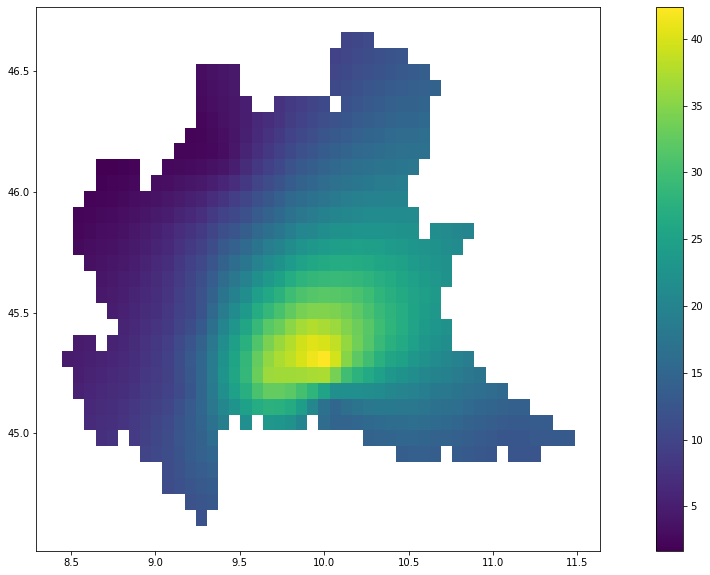

In [15]:
val = col.value
grid.plot(column = val, figsize=(20, 10), legend=True)